In [1]:
import numpy

\begin{align}
p_{i,j}^{n} &= \frac{1}{4}\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}+p_{i,j+1}^{n}+p_{i,j-1}^{n}\right) \\
&-\frac{\rho \Delta x}{16} \left( \frac{2}{\Delta t} \left(u_{i+1,j} - u_{i-1,j} + v_{i,j+1} - v_{i,j-1}\right) \right . \\
&-\frac{2}{\Delta x}\left(u_{i,j+1} - u_{i,j-1} \right) \left(v_{i+1,j} - v_{i-1,j} \right) \\
&- \left . \frac{\left(u_{i+1,j} - u_{i-1,j} \right)^2}{\Delta x} 
- \frac{ \left(v_{i,j+1} - v_{i,j-1} \right)^2 }{\Delta x} \right) \\
\end{align}

In [79]:
def velocity_term(b, rho, dt, u, v, dx):
    b[1:-1, 1:-1] = (
        rho * dx / 16 * 
        (2 / dt * (u[1:-1, 2:] - 
                   u[1:-1, :-2] + 
                   v[2:, 1:-1] - 
                   v[:-2, 1:-1]) - 
         2 / dx * (u[2:, 1:-1] - u[:-2, 1:-1]) * 
                  (v[1:-1, 2:] - v[1:-1, :-2]) -
        (u[1:-1, 2:] - u[1:-1, :-2])**2 / dx -
        (v[2:, 1:-1] - v[:-2, 1:-1])**2 / dx) 
                    )

    return b


In [80]:
def pressure_poisson(p, dx, dy, b, l2_target=1e-4):
    pn = p.copy()
    iter_diff = l2_target + 1
    while iter_diff > l2_target:
        n = 0
        pn = p.copy()
        p[1:-1,1:-1] = (.25 * (pn[1:-1, 2:] + pn[1:-1, :-2] + pn[2:, 1:-1] + pn[:-2, 1:-1])
                        - b[1:-1, 1:-1])
        
        p[:, 0] = p[:, 1]   #dp/dx = 0 at x = 0
        p[:, -1] = p[:, -2] #dp/dy = 0 at x = 2
        p[0, :] = p[1, :]   #dp/dy = 0 at y = 0
        p[-1, :] = 0        #p = 0 at y = 2      
        
        if n % 10 == 0:
            iter_diff = numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
        
        if n == 500:
            break
            
        n += 1
        
    return p

The momentum equation in the $u$ direction:

\begin{align}
u_{i,j}^{n+1} = u_{i,j}^{n} &- \frac{\Delta t}{\Delta x} \left( u_{i,j}^{n}(u_{i,j}^{n}-u_{i-1,j}^{n})
+ v_{i,j}^{n} (u_{i,j}^{n}-u_{i,j-1}^{n}) + \frac{1}{2 \rho}(p_{i+1,j}^{n}-p_{i-1,j}^{n}) \right) \\
&+\frac{\nu \Delta t}{\Delta x^2}\left(u_{i+1,j}^{n} + u_{i-1,j}^{n} + u_{i,j+1}^{n} + u_{i,j-1}^{n} -4u_{i,j}^{n}\right)
\end{align}

The momentum equation in the $v$ direction:

\begin{align}
v_{i,j}^{n+1} = v_{i,j}^{n} &- \frac{\Delta t}{\Delta x} \left( u_{i,j}^{n}(v_{i,j}^{n}-v_{i-1,j}^{n})
+ v_{i,j}^{n} (v_{i,j}^{n}-v_{i,j-1}^{n}) + \frac{1}{2 \rho}(p_{i,j+1}^{n}-p_{i,j-1}^{n}) \right) \\
&+\frac{\nu \Delta t}{\Delta x^2}\left(v_{i+1,j}^{n} + v_{i-1,j}^{n} + v_{i,j+1}^{n} + v_{i,j-1}^{n} -4v_{i,j}^{n}\right)
\end{align}



In [81]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    ny, nx = u.shape
    b = numpy.zeros((ny, nx))

    for n in range(nt):
        un = u.copy()
        vn = v.copy()

        b = velocity_term(b, rho, dt, u, v, dx)
        p = pressure_poisson(p, dx, dy, b, 1e-3)

        u[1:-1,1:-1] = (un[1:-1, 1:-1] - dt / dx * 
                        (un[1:-1,1:-1] * (un[1:-1, 1:-1] - 
                                          un[1:-1, :-2]) +
                        vn[1:-1, 1:-1 ] * (un[1:-1, 1:-1] - 
                                            un[:-2, 1:-1]) +
                        1 / (2 * rho) * (p[1:-1, 2:] - 
                                         p[1:-1, :-2])) + 
                          nu * dt / dx**2 *
                         (un[1:-1, 2:] + 
                          un[1:-1, :-2] + 
                          un[2:, 1:-1] + 
                          un[:-2, 1:-1] - 
                          4 * un[1:-1, 1:-1]))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] - dt / dx * 
                        (un[1:-1,1:-1] * (vn[1:-1, 1:-1] - 
                                          vn[1:-1, :-2]) +
                         vn[1:-1, 1:-1 ] * (vn[1:-1, 1:-1] - 
                                            vn[:-2, 1:-1]) +
                        1 / (2 * rho) * (p[2:, 1:-1] - 
                                         p[:-2, 1:-1])) + 
                        nu * dt / dx**2 *
                         (vn[1:-1, 2:] + 
                          vn[1:-1, :-2] + 
                          vn[2:, 1:-1] + 
                          vn[:-2, 1:-1] - 
                          4 * vn[1:-1, 1:-1]))

        u[:, 0] = 0
        u[:, -1] = 0
        v[:, 0] = 0
        v[:, -1] = 0
        
        u[0, :] = 0
        u[-1, :] = 1    #set velocity on cavity lid equal to 1
        v[0, :] = 0
        v[-1, :] = 0
        
        
        
    return u, v, p

In [82]:
import pickle

In [83]:
def run_cavity():
    nx = 41
    ny = 41
    with open('notebooks/IC.pickle', 'rb') as f:
        u, v, p, b = pickle.load(f)

    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    rho = 1
    nu = 0.1
    dt = .005

    nt = 500
    u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)
    return u, v, p

In [84]:
u, v, p = run_cavity()

In [85]:
from matplotlib import pyplot, cm
%matplotlib inline

In [86]:
nx = 41
ny = 41
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

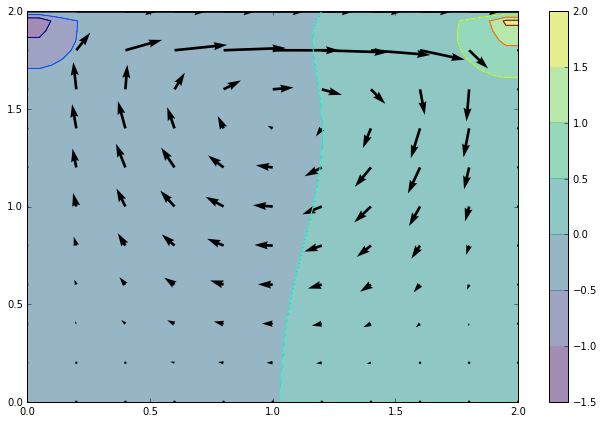

In [87]:
quiver_skip = qs = 4
pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p)
pyplot.quiver(X[::qs, ::qs], Y[::qs, ::qs], u[::qs, ::qs], v[::qs, ::qs])

In [ ]:
%%timeit
run_cavity()

In [90]:
%load_ext line_profiler

In [91]:
%lprun -f cavity_flow run_cavity()